# IAU 2023/2024
## **Autori:** Laura Fulajtárová (50%), Bruno Kristián (50%)

# Fáza 3 - Strojové učenie 

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import plot_tree
from IPython.display import Image
import copy
from collections import Counter
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

### OneR algoritmus

Dočasne sme spojili dáta z trénovacej a testovacej množiny, aby sme mohli vytvoriť OneR model. 

In [2]:
X_train = pd.read_csv("X_train.csv", sep=',')
y_train = pd.read_csv("y_train.csv", sep=',')
y_train = y_train.values.ravel()  # Converting y_train to a 1D array

# Convert y_train to a DataFrame
y_train_df = pd.DataFrame({'ack': y_train})  # Replace 'target_column_name' with the actual column name in y_train

merged_train_data = pd.concat([X_train, y_train_df], axis=1)
train_data = merged_train_data

X_test = pd.read_csv("X_test.csv", sep=',')
y_test = pd.read_csv("y_test.csv", sep=',')

merged_test_data = pd.concat([X_test, y_test], axis=1)
test_data = merged_test_data


One Rule algoritmus sme naprogramovali iba pre číselné hodnoty, pretože v dátach sme si v minulých fázach premenili pomocou encodingu všetky kategorické hodnoty na číselné.

In [3]:
def one_rule_algorithm(data, target_variable, explored_columns):
    best_feature = None
    best_accuracy = 0
    
    for feature in data.columns:
        if feature == target_variable or feature in explored_columns:
            continue
        
        mean_values = data.groupby(target_variable)[feature].mean()
        split_point = mean_values.mean()
        
        temp_data = data.copy()
        temp_data['prediction'] = temp_data[feature] > split_point
        
        accuracy = accuracy_score(temp_data[target_variable], temp_data['prediction'])
        precision = precision_score(temp_data[target_variable], temp_data['prediction'])
        recall = recall_score(temp_data[target_variable], temp_data['prediction'])
        
        if accuracy > best_accuracy:
            best_feature = feature
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            result = temp_data['prediction']
    
    return best_feature, best_accuracy, best_precision, best_recall, result

Spustíme algoritmus OneR s predikovanou premennou "ack" a vyhodnotíme metriky.

Na vyhodnotenie modelu sme použili nasledovné metriky:
- Accuracy - ako často klasiﬁkátor správne klasifikoval 

- Precision - koľko správne predikovaných príkladov bolo pozitívnych

- Recall - koľko pozitívnych príkladov bolo správne predikovaných

### OneR s jednou premennou

In [4]:
target_variable = 'ack'

oneR_train_data = copy.deepcopy(train_data)
oneR_test_data = copy.deepcopy(test_data)

best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(oneR_train_data, target_variable, [])
print('Best column from OneR:', best_feature)
print('Accuracy:', best_accuracy)
print('\n')

oneR_train_data[[best_feature, 'ack']]
best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(oneR_test_data, target_variable, [])
print('Best column from OneR:', best_feature)
print('Accuracy:', best_accuracy)
print('Precision:', best_precision)
print('Recall:', best_recall)


Best column from OneR: page_activity_duration
Accuracy: 0.8994723687864482


Best column from OneR: page_activity_duration
Accuracy: 0.9056603773584906
Precision: 0.8571428571428571
Recall: 0.96


Vidíme, že algoritmus vyhodnotil "page_activity_duration" ako najlepšiu premennú pre predikciu "ack". Algoritmus na základe premennej "page_activity_duration" predikoval s presnosťou takmer 90%.

### OneR s viacerými premennými

Teraz skúsime spustiť OneR algoritmus viackrát a zistiť ktoré premenné najlepšie predikujú "ack".

Po zistení najlepších premenných ich použijeme na vytvorenie modelu. Pri vytváraní modelu prihliadame na presnosť predikcie danej premennej. Čím vyššia presnosť, tým má vyššiu váhu pri rozhodaovaní. 

In [5]:
target_variable = 'ack'
results = []
explored_columns = []
final_results = []

for _ in range(5):
    oneR_train_data = copy.deepcopy(train_data)
    best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(oneR_train_data, target_variable, explored_columns)
    explored_columns.append(best_feature)
    results.append((best_accuracy, prediction.tolist()))

for result in results:
    if result[0] > 0.7:
        final_results.append(result[1])
        final_results.append(result[1])
    else:
        final_results.append(result[1])

combined_predictions = [Counter(sample).most_common(1)[0][0] for sample in zip(*final_results)]

overall_accuracy = accuracy_score(train_data[target_variable], combined_predictions)
overall_precision = precision_score(train_data[target_variable], combined_predictions, zero_division=0)
overall_recall = recall_score(train_data[target_variable], combined_predictions)

table_data = {
    "Algorithm": ["OneR"],
    "Accuracy": [overall_accuracy],
    "Precision": [overall_precision],
    "Recall": [overall_recall]
}

oneR_table = pd.DataFrame(table_data)

Najlepšie premenné k predikcií "ack"

In [6]:
table_data = {
    "Feature": explored_columns,
    "Accuracy": [result[0] for result in results]
}

accuracy_table = pd.DataFrame(table_data)
accuracy_table

,Feature,Accuracy
0,page_activity_duration,0.899472
1,pct_input,0.628159
2,pct_doubleclick,0.605110
3,wild_mouse_duration,0.581505
4,pct_click,0.575396


Výsledky metrík pre predikovanie premennej "ack" pomocou OneR algoritmu s viacerými premennými.

In [7]:
print('Overall Accuracy:', overall_accuracy)
print('Overall Precision:', overall_precision)
print('Overall Recall:', overall_recall)

Overall Accuracy: 0.8339350180505415
Overall Precision: 0.8271166370633511
Overall Recall: 0.82031708749266


### Scikit-learn Klasifikátory

Stromový klasifikátor Random Forest.

In [8]:
"""# Analysis for varying model complexity
results = []
max_depth_range = range(1, 30)  # Varying max_depth from 1 to 20

for depth in max_depth_range:
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=1)
    rf_model.fit(X_train, y_train)
    
    # Calculate error on training set
    train_pred = rf_model.predict(X_train)
    train_error = 1 - accuracy_score(y_train, train_pred)

    # Calculate error on test set
    test_pred = rf_model.predict(X_test)
    test_error = 1 - accuracy_score(y_test, test_pred)

    results.append({'max_depth': depth, 'train_error': train_error, 'test_error': test_error})

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Find the max_depth with the lowest test error
optimal_depth = results_df['max_depth'][results_df['test_error'].idxmin()]

# Plotting the errors vs model complexity
plt.figure(figsize=(10, 6))
plt.plot(results_df['max_depth'], results_df['train_error'], label='Training Error', marker='o', color='blue')
plt.plot(results_df['max_depth'], results_df['test_error'], label='Testing Error', marker='o', color='red')

# Add vertical line at the point of lowest test error
plt.axvline(x=optimal_depth, color='green', linestyle='--', label=f'Optimal Depth: {optimal_depth}')

plt.title("Error vs. Model Complexity (Max Depth)")
plt.xlabel("Max Depth")
plt.ylabel("Error (1 - Accuracy)")
plt.legend()
plt.grid()
plt.show()

# Display the optimal depth and corresponding errors
optimal_info = results_df.loc[results_df['max_depth'] == optimal_depth]
optimal_info"""

'# Analysis for varying model complexity\nresults = []\nmax_depth_range = range(1, 30)  # Varying max_depth from 1 to 20\n\nfor depth in max_depth_range:\n    rf_model = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=1)\n    rf_model.fit(X_train, y_train)\n    \n    # Calculate error on training set\n    train_pred = rf_model.predict(X_train)\n    train_error = 1 - accuracy_score(y_train, train_pred)\n\n    # Calculate error on test set\n    test_pred = rf_model.predict(X_test)\n    test_error = 1 - accuracy_score(y_test, test_pred)\n\n    results.append({\'max_depth\': depth, \'train_error\': train_error, \'test_error\': test_error})\n\n# Convert results to a DataFrame for easier plotting\nresults_df = pd.DataFrame(results)\n\n# Find the max_depth with the lowest test error\noptimal_depth = results_df[\'max_depth\'][results_df[\'test_error\'].idxmin()]\n\n# Plotting the errors vs model complexity\nplt.figure(figsize=(10, 6))\nplt.plot(results_df[\'max_depth\'],

In [9]:
results = []
estimators = []

clf = RandomForestClassifier(max_depth = 17, min_samples_split = 6, min_samples_leaf = 4)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

accuracy = accuracy_score(y_test, predictions)
accuracy_train = accuracy_score(y_train, train_predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy Train: {accuracy_train:.2f}")
print('\n')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

table_data = {
    "Algorithm": ["Random Forest"],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall]
}

RF_table = pd.DataFrame(table_data)

feature_importances = clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_5_features_rf = sorted_indices[:5]
top_5_importances = feature_importances[top_5_features_rf]

feature_names = X_test.columns.values

top_5_feature_names_rf = [feature_names[i] for i in top_5_features_rf]

Accuracy Train: 0.98


Accuracy: 0.96
Precision: 0.94
Recall: 0.97


Stromový klasifikátor Gradient Boosting.

In [10]:
"""# Analysis for varying model complexity
results = []
max_depth_range = range(1, 15)  # Varying max_depth from 1 to 15

for depth in max_depth_range:
    gb_model = GradientBoostingClassifier(max_depth=depth)
    gb_model.fit(X_train, y_train)
    
    # Calculate error on training set
    train_pred = gb_model.predict(X_train)
    train_error = 1 - accuracy_score(y_train, train_pred)

    # Calculate error on test set
    test_pred = gb_model.predict(X_test)
    test_error = 1 - accuracy_score(y_test, test_pred)

    results.append({'max_depth': depth, 'train_error': train_error, 'test_error': test_error})

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Find the max_depth with the lowest test error
optimal_depth = results_df['max_depth'][results_df['test_error'].idxmin()]

# Plotting the errors vs model complexity
plt.figure(figsize=(10, 6))
plt.plot(results_df['max_depth'], results_df['train_error'], label='Training Error', marker='o', color='blue')
plt.plot(results_df['max_depth'], results_df['test_error'], label='Testing Error', marker='o', color='red')

# Add vertical line at the point of lowest test error
plt.axvline(x=optimal_depth, color='green', linestyle='--', label=f'Optimal Depth: {optimal_depth}')

plt.title("Error vs. Model Complexity (Max Depth)")
plt.xlabel("Max Depth")
plt.ylabel("Error (1 - Accuracy)")
plt.legend()
plt.grid()
plt.show()

# Display the optimal depth and corresponding errors
optimal_info = results_df.loc[results_df['max_depth'] == optimal_depth]
optimal_info"""

'# Analysis for varying model complexity\nresults = []\nmax_depth_range = range(1, 15)  # Varying max_depth from 1 to 15\n\nfor depth in max_depth_range:\n    gb_model = GradientBoostingClassifier(max_depth=depth)\n    gb_model.fit(X_train, y_train)\n    \n    # Calculate error on training set\n    train_pred = gb_model.predict(X_train)\n    train_error = 1 - accuracy_score(y_train, train_pred)\n\n    # Calculate error on test set\n    test_pred = gb_model.predict(X_test)\n    test_error = 1 - accuracy_score(y_test, test_pred)\n\n    results.append({\'max_depth\': depth, \'train_error\': train_error, \'test_error\': test_error})\n\n# Convert results to a DataFrame for easier plotting\nresults_df = pd.DataFrame(results)\n\n# Find the max_depth with the lowest test error\noptimal_depth = results_df[\'max_depth\'][results_df[\'test_error\'].idxmin()]\n\n# Plotting the errors vs model complexity\nplt.figure(figsize=(10, 6))\nplt.plot(results_df[\'max_depth\'], results_df[\'train_error\'], 

In [11]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=1, max_depth = 8)

gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)
gb_y_pred_train = gb_model.predict(X_train)

gb_trin_accuracy = accuracy_score(y_train, gb_y_pred_train)
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision = precision_score(y_test, gb_y_pred)
gb_recall = recall_score(y_test, gb_y_pred)

print(f"Accuracy Train: {gb_trin_accuracy:.2f}")
print('\n')
print(f"Accuracy: {gb_accuracy:.2f}")
print(f"Precision: {gb_precision:.2f}")
print(f"Recall: {gb_recall:.2f}")

table_data = {
    "Algorithm": ["Gradient Boosting"],
    "Accuracy": [gb_accuracy],
    "Precision": [gb_precision],
    "Recall": [gb_recall]
}

GB_table = pd.DataFrame(table_data)

feature_importances = gb_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_5_features_gb = sorted_indices[:5]
top_5_importances = feature_importances[top_5_features_gb]
feature_names = X_test.columns.values

top_5_feature_names = [feature_names[i] for i in top_5_features_gb]

Accuracy Train: 1.00


Accuracy: 0.97
Precision: 0.95
Recall: 0.98


### Nestromový algoritmus

Pre nestromový algoritmus sme si vybrali KNN klasifikátor.

Najskôr si dáta scalujeme a normalizujeme, aby KNN klasifikátor pracoval efektívnejšie.

In [12]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_train)
train_data_scaled = pd.DataFrame(scaled_data, columns=X_train.columns)

power = PowerTransformer(method='yeo-johnson', standardize=True) 
X_train_normalised = power.fit_transform(train_data_scaled)
X_train_scaled_normalised = pd.DataFrame(X_train_normalised, columns=X_train.columns)

scaled_test_data = scaler.transform(X_test)
test_data_scaled = pd.DataFrame(scaled_test_data, columns=X_test.columns)

normalized_test_data = power.transform(test_data_scaled)
test_data_scaled_normalized = pd.DataFrame(normalized_test_data, columns=X_test.columns)

Pri stromových klasifikačných algoritmoch sme nemuseli použiť feature selection, pretože si s tým poradili samé. Pri nestromových algoritmoch je to však inak.

In [13]:
columns_to_keep = [
    'page_activity_duration', 'pct_doubleclick', 'pct_mouse_click', 'wild_mouse_duration',
    'pct_mouse_move', 'pct_input', 'pct_click', 'session_start', 
    'scroll_move_total_rel_distance', 'pct_scroll_move'
]

X_train_filtered = X_train_scaled_normalised[columns_to_keep]
X_test_filtered = test_data_scaled_normalized[columns_to_keep]

KNN klasifikátor

In [14]:
knn_model = KNeighborsClassifier(n_neighbors=10)

knn_model.fit(X_train_filtered, y_train)

knn_y_pred = knn_model.predict(X_test_filtered)
knn_y_pred_train = knn_model.predict(X_train_filtered)

knn_trin_accuracy = accuracy_score(y_train, knn_y_pred_train)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print(f"Accuracy Train: {knn_trin_accuracy:.2f}")
print('\n')
print(f"Accuracy: {knn_accuracy:.2f}")
print(f"Precision: {knn_precision:.2f}")
print(f"Recall: {knn_recall:.2f}")

table_data_knn = {
    "Algorithm": ["K-Nearest Neighbors"],
    "Accuracy": [knn_accuracy],
    "Precision": [knn_precision],
    "Recall": [knn_recall]
}

knn_table = pd.DataFrame(table_data_knn)

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_train_filtered, y_train)
top_5_indices = selector.get_support(indices=True)
top_5_features_knn = X_train_filtered.columns[top_5_indices]

Accuracy Train: 0.96


Accuracy: 0.97
Precision: 0.96
Recall: 0.97


#### Porovnanie výsledkov

In [15]:
display(oneR_table, RF_table, GB_table, knn_table)

,Algorithm,Accuracy,Precision,Recall
0,OneR,0.833935,0.827117,0.820317


,Algorithm,Accuracy,Precision,Recall
0,Random Forest,0.955605,0.936508,0.971765


,Algorithm,Accuracy,Precision,Recall
0,Gradient Boosting,0.966704,0.954023,0.976471


,Algorithm,Accuracy,Precision,Recall
0,K-Nearest Neighbors,0.965594,0.95814,0.969412


Z porovnania výsledkov vidíme, že najlepšie výsledky dosiahol Gradient Boosting klasifikátor.

Náš oneR algoritmus dosiahol presnosť 83%. Dôvodom je jednoduchosť algoritmu a potreba predikovať pomocou viacerých premenných. Keďže najlepší atribút má presnosť okolo 90% a ostané atribúty majú presnosť len okolo 60%, tak pri predikovaní pomocou viacerých atribútov sa presnosť zníži.

OneR algoritmus predikuje s precíznosťou 82%, čo je o viac ako 10% menej ako Gradient Boosting klasifikátor alebo Random Forest klasifikátor.

Náš algoritmus je o 15% horší ako ako Gradient Boosting klasifikátor alebo Random Forest klasifikátor v predikovaní pozitívnych príkladov zo všetkých pozitívnych príkladov.

In [16]:
print("One Rule Algorithm:")
for column in explored_columns:
    print(column)


print("\n")
print("Random Forest:")
for column in top_5_feature_names_rf:
    print(column)


print("\n")
print("Gradient Boosting:")
for column in top_5_feature_names:
    print(column)

print("\n")
print("K Nearest Neighbours:")
for column in top_5_features_knn:
    print(column)

One Rule Algorithm:
page_activity_duration
pct_input
pct_doubleclick
wild_mouse_duration
pct_click


Random Forest:
page_activity_duration
pct_doubleclick
pct_mouse_move
pct_input
wild_mouse_duration


Gradient Boosting:
page_activity_duration
pct_doubleclick
pct_mouse_move
pct_mouse_click
pct_click


K Nearest Neighbours:
page_activity_duration
pct_doubleclick
pct_mouse_move
pct_input
pct_click


Vidíme, že algoritmy sa podobajú vo výbere atribútov, ktoré najlepšie predikujú "ack". Najlepšie atribúty sú "page_activity_duration", "pct_doubleclick" a "pct_click".

#### Vizualizácia natrénovaných pravidiel

Vizualizujeme si Random Forest klasifikátor.

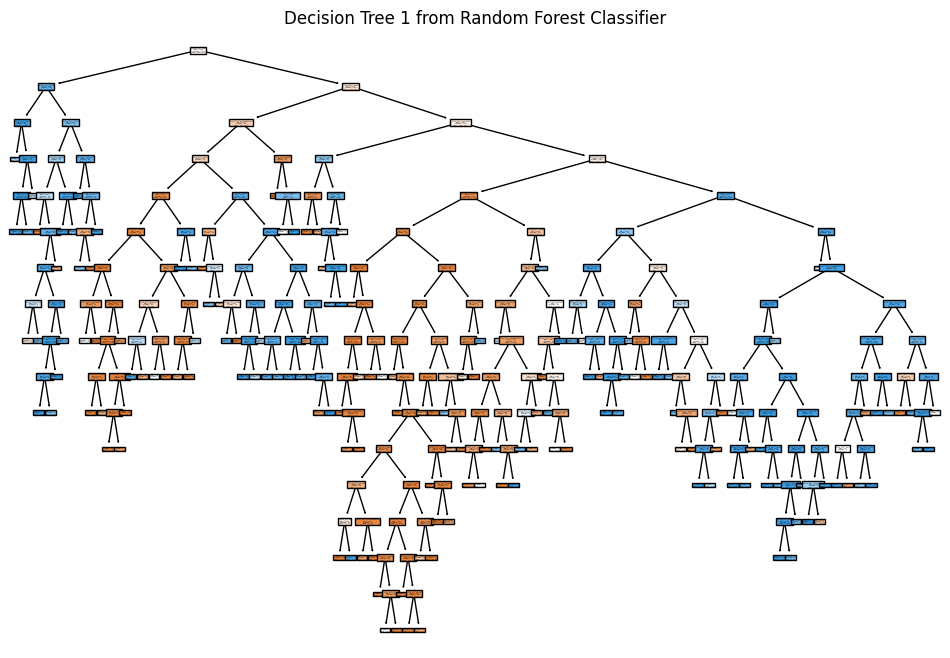

In [17]:
tree_index = 0
plt.figure(figsize=(12, 8))
plot_tree(clf.estimators_[tree_index], filled=True, feature_names=[f"feature_{i}" for i in range(X_test.shape[1])])
plt.title(f"Decision Tree {tree_index + 1} from Random Forest Classifier")
plt.show()

Vizualizácia pravidiel pre Random Forest klasifikátor na základe accuracy.

In [18]:
"""import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

feature_accuracies = []

for i in range(X_train.shape[1]):
    X_train_single_feature = X_train.iloc[:, i:i+1]  # Assuming X_train is a DataFrame
    X_test_single_feature = X_test.iloc[:, i:i+1]    # Assuming X_test is a DataFrame
    
    clf_single_feature = RandomForestClassifier()
    clf_single_feature.fit(X_train_single_feature, y_train)  # No need for .values here
    
    predictions_single_feature = clf_single_feature.predict(X_test_single_feature)
    
    accuracy_single_feature = accuracy_score(y_test, predictions_single_feature)
    feature_accuracies.append((X_train.columns[i], accuracy_single_feature))

sorted_features = sorted(feature_accuracies, key=lambda x: x[1], reverse=True)

top_5_feature_names = [feat[0] for feat in sorted_features[:5]]
top_5_accuracies = [feat[1] for feat in sorted_features[:5]]

plt.figure(figsize=(10, 6))
plt.bar(top_5_feature_names, top_5_accuracies, color='skyblue')
plt.xlabel('Feature Name')
plt.ylabel('Accuracy')
plt.title('Top 5 Features with Accuracies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
"""

"import matplotlib.pyplot as plt\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score\n\nfeature_accuracies = []\n\nfor i in range(X_train.shape[1]):\n    X_train_single_feature = X_train.iloc[:, i:i+1]  # Assuming X_train is a DataFrame\n    X_test_single_feature = X_test.iloc[:, i:i+1]    # Assuming X_test is a DataFrame\n    \n    clf_single_feature = RandomForestClassifier()\n    clf_single_feature.fit(X_train_single_feature, y_train)  # No need for .values here\n    \n    predictions_single_feature = clf_single_feature.predict(X_test_single_feature)\n    \n    accuracy_single_feature = accuracy_score(y_test, predictions_single_feature)\n    feature_accuracies.append((X_train.columns[i], accuracy_single_feature))\n\nsorted_features = sorted(feature_accuracies, key=lambda x: x[1], reverse=True)\n\ntop_5_feature_names = [feat[0] for feat in sorted_features[:5]]\ntop_5_accuracies = [feat[1] for feat in sorted_features[:5]]\n\nplt.figure(figs

### Hyperparameter tuning

#### Gradient Boosting classifier

Gradient Boosting je veľmi presný model, obzvlášť účinný pri práci s komplexnými dátami, čo je výhodné v rôznych aplikáciách od klasifikácie po regresiu. Jeho flexibilita umožňuje prispôsobenie rozličným typom stratových funkcií, čo ho robí vhodným pre rôzne prediktívne úlohy. Okrem toho, ponúka viacero možností na kontrolu overfittingu, ako napríklad nastavenie hĺbky stromu a rýchlosti učenia, čo zlepšuje jeho schopnosť generalizovať na nevidené dáta.

##### Vysvetlenie hyperparametrov

In [19]:
params = GradientBoostingClassifier().get_params()
for key, value in params.items():
    print(f"{key}: {value}")

ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: log_loss
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_iter_no_change: None
random_state: None
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False


- ccp_alpha: Komplexita stromu. Čím vyššia hodnota, tým viac sa strom zjednoduší.
- criterion: Kritérium pre výber atribútu, ktorý sa použije na rozdelenie uzla.
- init: Inicializácia stromu.
- learning_rate: Rýchlosť učenia.
- loss: Funkcia straty.
- max_depth: Maximálna hĺbka stromu.
- max_features: Maximálny počet atribútov, ktoré sa použijú na rozdelenie uzla.
- max_leaf_nodes: Maximálny počet listových uzlov.
- min_impurity_decrease: Uzol sa rozdelí, ak sa impurity v jeho rodičovskom uzle zníži o túto hodnotu.
- min_samples_leaf: Minimálny počet vzoriek v listovom uzle.
- min_weight_fraction_leaf: Minimálna váhová frakcia v listovom uzle.
- n_estimators: Počet stromov v ensemble.
- n_iter_no_change: Počet iterácií bez zlepšenia pred ukončením učenia.
- random_state: Seed pre generovanie náhodných čísel.
- subsample: Podiel vzoriek použitých na trénovanie každého stromu.
- tol: Tolerancia pre zastavenie učenia.
- validation_fraction: Podiel vzoriek použitých na validáciu každého stromu.
- verbose: Výpis informácií o učení.
- warm_start: Použiť existujúci model na trénovanie a pridať ďalšie stromy do ensemble.

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Adjusted parameter grid to combat overfitting
gb_parameters = {
    'criterion': ['friedman_mse', 'squared_error'],
    'loss': ['log_loss', 'exponential'],
    'max_depth': [3, 4, 5],  
    'n_estimators': [80,100, 120], 
    'learning_rate': [0.09, 0.1, 0.11],
    'random_state': [None, 1],
    'min_samples_split': [3, 4, 5],  
    'min_samples_leaf': [2, 3, 4] 
}

# Initialize RandomizedSearchCV
gb_clf = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(), 
    param_distributions=gb_parameters,
    cv=5,
    n_iter=10,
    n_jobs=-1
)

# Fit the random search
gb_search = gb_clf.fit(X_train, y_train)

# Output the results
print("Best Estimator:", gb_search.best_estimator_)
print("Best Score:", gb_search.best_score_)
print("Best Parameters:", gb_search.best_params_)

# Train the best model on the entire training data and get feature importances
best_gb_model = gb_search.best_estimator_.fit(X_train, y_train)
feature_importances = best_gb_model.feature_importances_

# Select the top N features (choose N, e.g., top 5)
N = 5
top_features_indices = feature_importances.argsort()[-N:][::-1]
top_features = [X_train.columns[i] for i in top_features_indices]

# Restrict your training and testing sets to these top features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Train and evaluate your model on this reduced feature set
final_model = gb_search.best_estimator_.fit(X_train_reduced, y_train)


# Evaluate the performance of the final model
final_model_score = final_model.score(X_test_reduced, y_test)
print("Final Model Score on Test Data:", final_model_score)


Best Estimator: GradientBoostingClassifier(learning_rate=0.09, max_depth=5, min_samples_leaf=4,
                           min_samples_split=4, n_estimators=120)
Best Score: 0.9480698104484512
Best Parameters: {'random_state': None, 'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5, 'loss': 'log_loss', 'learning_rate': 0.09, 'criterion': 'friedman_mse'}
Final Model Score on Test Data: 0.9600443951165372


##### Gradient Boosting before hyperparameter tuning

In [21]:
gb_model = GradientBoostingClassifier()

gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision2 = precision_score(y_test, gb_y_pred)
gb_recall2 = recall_score(y_test, gb_y_pred)

print(f"Accuracy: {gb_accuracy:.5f}")
print(f"Precision: {gb_precision2:.5f}")
print(f"Recall: {gb_recall2:.5f}")

Accuracy: 0.96226
Precision: 0.94331
Recall: 0.97882


In [22]:
def evaluate_model_performance(clf, X_train, y_train, X_test, y_test):
    # Fit the model
    clf.fit(X_train, y_train)

    # Predictions on training and test data
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_precision = precision_score(y_train, train_predictions)
    train_recall = recall_score(y_train, train_predictions)

    # Calculate metrics for test data
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions)
    test_recall = recall_score(y_test, test_predictions)

    # Print training metrics
    print("Training Metrics:")
    print(f"Accuracy: {train_accuracy:.5f}")
    print(f"Precision: {train_precision:.5f}")
    print(f"Recall: {train_recall:.5f}\n")

    # Print test metrics
    print("Test Metrics:")
    print(f"Accuracy: {test_accuracy:.5f}")
    print(f"Precision: {test_precision:.5f}")
    print(f"Recall: {test_recall:.5f}\n")

    # Check for Underfitting
    if train_accuracy < 0.6 and test_accuracy < 0.6:
        print("The model is underfitting.")
    else:
        print(f"The model is not underfitting because the training and test accuracies are {train_accuracy:.5f} and {test_accuracy:.5f}.")

    # Check for Overfitting
    if train_accuracy > 0.8 and (train_accuracy - test_accuracy) > 0.1 or train_accuracy == 1.0:
        print("The model is overfitting.")
    else:
        print(f"The model is not overfitting because the difference between the training and test accuracies is {train_accuracy - test_accuracy:.5f}.")

    # Check for Stability
    if abs(train_accuracy - test_accuracy) < 0.1:
        print(f"The model is stable because the difference between the training and test accuracies is {abs(train_accuracy - test_accuracy):.5f}.")
    else:
        print("The model is not stable.")


##### Gradient Boosting after hyperparameter tuning

In [23]:
clf = gb_search.best_estimator_
evaluate_model_performance(clf, X_train_reduced, y_train, X_test_reduced, y_test)

Training Metrics:
Accuracy: 0.98167
Precision: 0.97670
Recall: 0.98473

Test Metrics:
Accuracy: 0.96004
Precision: 0.94713
Recall: 0.96941

The model is not underfitting because the training and test accuracies are 0.98167 and 0.96004.
The model is not overfitting because the difference between the training and test accuracies is 0.02163.
The model is stable because the difference between the training and test accuracies is 0.02163.


#### Random Forest classifier

Random Forest je obľúbený pre svoju robustnosť a výkonnosť, ktorá je často porovnateľná s komplexnejšími modelmi. Vďaka svojmu spôsobu náhodnej výberu prvkov a tvorby stromov poskytuje Random Forest vynikajúcu odolnosť voči overfittingu. Táto metóda je tiež schopná efektívne spracovávať veľké dátove sady s veľkým počtom premenných, čo je výhodné pri riešení širokej škály úloh prediktívnej analýzy.

##### Vysvetlenie hyperparametrov

In [24]:
params = RandomForestClassifier().get_params()
for key, value in params.items():
    print(f"{key}: {value}")

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


- bootstrap: Použiť bootstrap vzorkovanie. Bootstrap vzorkovanie je metóda, ktorá sa používa na zlepšenie presnosti modelu.
- class_weight: Váhy tried.
- max_samples: Maximálny počet vzoriek použitých na trénovanie každého stromu.
-  n_jobs: Počet jadier procesora použitých na trénovanie.
-  oob_score: Použiť out-of-bag vzorky na odhad presnosti. Out-of-bag vzorky sú vzorky, ktoré neboli použité na trénovanie stromu.

In [25]:
estimator = RandomForestClassifier()

# Random Forest Parameters
rf_parameters = {
    'n_estimators': [100,120,140,160],
    'max_depth': [ 3,5,7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2,3,4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

scoring = ['accuracy', 'precision_micro']

rf_clf = RandomizedSearchCV(
    estimator=estimator, 
    param_distributions=rf_parameters, 
    cv=5, 
    n_jobs=-1,
    n_iter=10,
)

rf_search = rf_clf.fit(X_train, y_train)

# Output the results
print("Best Estimator:", rf_search.best_estimator_)
print("Best Score:", rf_search.best_score_)
print("Best Parameters:", rf_search.best_params_)
print("Number of Splits:", rf_search.n_splits_)

# Feature Importance and Selection
best_rf_model = rf_search.best_estimator_.fit(X_train, y_train)
rf_feature_importances = best_rf_model.feature_importances_

# Select the top N features (e.g., top 5)
N = 5
rf_top_features_indices = rf_feature_importances.argsort()[-N:][::-1]
rf_top_features = [X_train.columns[i] for i in rf_top_features_indices]

# Restrict your training and testing sets to these top features
X_train_reduced = X_train[rf_top_features]
X_test_reduced = X_test[rf_top_features]

Best Estimator: RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=7,
                       max_features='log2', min_samples_leaf=3)
Best Score: 0.9266859300354445
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
Number of Splits: 5


##### Random Forest before hyperparameter tuning

In [26]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")

Accuracy: 0.95893
Precision: 0.94091
Recall: 0.97412


##### Random Forest after hyperparameter tuning

In [27]:
clf = rf_search.best_estimator_
evaluate_model_performance(clf, X_train_reduced, y_train, X_test_reduced, y_test)

Training Metrics:
Accuracy: 0.96279
Precision: 0.95216
Recall: 0.97005

Test Metrics:
Accuracy: 0.96226
Precision: 0.94737
Recall: 0.97412

The model is not underfitting because the training and test accuracies are 0.96279 and 0.96226.
The model is not overfitting because the difference between the training and test accuracies is 0.00052.
The model is stable because the difference between the training and test accuracies is 0.00052.


#### KNeighbors classifier

K-Nearest Neighbors (KNN) je známy svojou jednoduchosťou a intuitívnosťou, čo uľahčuje jeho pochopenie a implementáciu. Jeho flexibilita výberu počtu susedov a metrík vzdialenosti umožňuje prispôsobiť model špecifickým potrebám dát. Navyše, KNN je efektívny pri zachytávaní komplexných vzorov v dátach, čo je výhodné, keď sú presné predpovede založené na podobnosti dát kľúčové.

##### Vysvetlenie hyperparametrov


In [28]:
params = KNeighborsClassifier().get_params()
for key, value in params.items():
    print(f"{key}: {value}")

algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform


- algorithm: Algoritmus použitý na nájdenie najbližších susedov. Algoritmus môže byť "ball_tree", "kd_tree", "brute" alebo "auto".
- leaf_size: Veľkosť listového uzla.
- metric: Metrika použitá na výpočet vzdialenosti medzi bodmi. Metrika môže byť "euclidean", "manhattan" alebo "minkowski".
- n_neighbors: Počet najbližších susedov.
- p: Parameter pre metriku "minkowski".
- weights: Váhy použité na predikciu bodu. Váhy môžu byť "uniform" alebo "distance".

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# KNN Parameters
knn_parameters = {
    'n_neighbors': [5, 10,15,20],  
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 50],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

scoring = ['accuracy', 'precision_micro']

knn_clf = RandomizedSearchCV(
    estimator=KNeighborsClassifier(), 
    param_distributions=knn_parameters, 
    scoring=scoring,
    refit='accuracy', 
    cv=5, 
    n_jobs=-1
)

knn_search = knn_clf.fit(X_train_reduced, y_train)

# Output the results
print("Best Estimator:", knn_search.best_estimator_)
print("Best Score:", knn_search.best_score_)
print("Best Parameters:", knn_search.best_params_)
print("Number of Splits:", knn_search.n_splits_)



Best Estimator: KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=10)
Best Score: 0.9563996763754045
Best Parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 10, 'metric': 'euclidean', 'leaf_size': 30, 'algorithm': 'brute'}
Number of Splits: 5


##### KNN before hyperparameter tuning

In [30]:
knn_model = KNeighborsClassifier()

knn_model.fit(X_train_filtered, y_train)

knn_y_pred = knn_model.predict(X_test_filtered)

knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print(f"Accuracy: {knn_accuracy:.5f}")
print(f"Precision: {knn_precision:.5f}")
print(f"Recall: {knn_recall:.5f}")

Accuracy: 0.95450
Precision: 0.95070
Recall: 0.95294


##### KNN after hyperparameter tuning

In [31]:
clf = knn_search.best_estimator_
evaluate_model_performance(clf, X_train_reduced, y_train, X_test_reduced, y_test)

Training Metrics:
Accuracy: 0.95723
Precision: 0.95055
Recall: 0.95948

Test Metrics:
Accuracy: 0.96559
Precision: 0.95392
Recall: 0.97412

The model is not underfitting because the training and test accuracies are 0.95723 and 0.96559.
The model is not overfitting because the difference between the training and test accuracies is -0.00836.
The model is stable because the difference between the training and test accuracies is 0.00836.


#### Voting ensemble 

In [32]:
from sklearn.ensemble import VotingClassifier

# Create individual models with their best parameters
model1 = gb_search.best_estimator_
model2 = rf_search.best_estimator_
model3 = knn_search.best_estimator_

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[('gb', model1), ('rf', model2), ('knn', model3)],
    voting='hard'
)

# Fit the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate the model
voting_score = voting_clf.score(X_test, y_test)
print(f"Voting Classifier Score: {voting_score}")


Voting Classifier Score: 0.9578246392896781


In [33]:
clf = voting_clf
evaluate_model_performance(clf, X_train_reduced, y_train, X_test_reduced, y_test)

Training Metrics:
Accuracy: 0.96612
Precision: 0.95879
Recall: 0.97005

Test Metrics:
Accuracy: 0.96670
Precision: 0.95195
Recall: 0.97882

The model is not underfitting because the training and test accuracies are 0.96612 and 0.96670.
The model is not overfitting because the difference between the training and test accuracies is -0.00058.
The model is stable because the difference between the training and test accuracies is 0.00058.


#### Stacking ensemble

In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Create individual models with their best parameters
model1 = gb_search.best_estimator_
model2 = rf_search.best_estimator_
model3 = knn_search.best_estimator_

# Define the stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[('gb', model1), ('rf', model2), ('knn', model3)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the model
stacking_score = stacking_clf.score(X_test, y_test)
print(f"Stacking Classifier Score: {stacking_score}")


Stacking Classifier Score: 0.9655937846836848


In [35]:
clf = stacking_clf
evaluate_model_performance(clf, X_train_reduced, y_train, X_test_reduced, y_test)

Training Metrics:
Accuracy: 0.96390
Precision: 0.95753
Recall: 0.96653

Test Metrics:
Accuracy: 0.96670
Precision: 0.95195
Recall: 0.97882

The model is not underfitting because the training and test accuracies are 0.96390 and 0.96670.
The model is not overfitting because the difference between the training and test accuracies is -0.00280.
The model is stable because the difference between the training and test accuracies is 0.00280.


Použitá literatúra:
- https://github.com/thismlguy/analytics_vidhya/tree/master/Articles/Parameter_Tuning_GBM_with_Example
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
